In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Imports**

In [1]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 13.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import os
import math
import json
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
import glob
from PIL import Image

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim
from tqdm import tqdm
import torchvision
from torchvision import transforms as T
from torchvision.utils import make_grid
from torchvision.transforms import functional as F

# **Arguments**

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cuda'

# **Functions**

In [5]:
import math
def train_one_epoch(model, optimizer, train_loader, epoch=None):
    model.train()
    total_loss = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        for images, targets in tepoch:
            if epoch is not None:
                tepoch.set_description(f"Epoch {epoch}")
                
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            tepoch.set_postfix(loss=losses.item())
    return model, total_loss/len(train_loader)

In [41]:
def test(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        cnt = 0
        for images , targets in test_dataloader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            out = model(images)
            labels = out[0]['labels'].cpu().numpy()
            scores = out[0]['scores'].cpu().numpy()
            bbox = out[0]['boxes'].cpu().numpy()
            
            img = images[0].permute(1, 2, 0).cpu().numpy()
            #----------------------------------------------------------
            fig, ax = plt.subplots(1)
            ax.imshow(img)
            for j in range(len(bbox)):
                if scores[j]>0.8:
                    rect = patches.Rectangle((bbox[j][0].item(),bbox[j][1].item()),
                                              bbox[j][2].item(),
                                              bbox[j][3].item(),
                                              linewidth=2,edgecolor='r',facecolor='none')
                    ax.add_patch(rect)
                    rx, ry = rect.get_xy()
                    cx = rx + rect.get_width()
                    cy = ry + rect.get_height()/500.
                    class_name = id_to_cat[id_to_cat['encoded_ids']==labels[j].item()]['cat_name'].values[0]
                    ax.annotate(class_name, (cx, cy), color='white', weight='bold', fontsize=10, ha='center', va='center', backgroundcolor='red')
            cnt = cnt + 1

# **Load Data**

In [7]:
with open('/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json', 'r') as f:
    json_file = json.load(f)
    ids = []
    names = []
    for item in json_file['categories']:
        ids.append(item['id'])
        names.append(item['name'])
    id_to_cat = pd.DataFrame({'class_id':ids, 'cat_name':names})
id_to_cat

class_id    cat_name
0          1      person
1          2     bicycle
2          3         car
3          4  motorcycle
4          5    airplane
..       ...         ...
75        86        vase
76        87    scissors
77        88  teddy bear
78        89  hair drier
79        90  toothbrush

[80 rows x 2 columns]

In [8]:
id_to_cat['class_id'].values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90])

In [9]:
id_to_cat['encoded_ids'] = id_to_cat['class_id'].replace({81:12, 82:26, 84:29, 85:30, 86:45, 87:66, 88:68, 89:69, 90:71}).values - 1

In [10]:
id_to_cat['encoded_ids'].values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 26, 27, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 69, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 11, 25, 28, 29, 44, 65, 67, 68, 70])

In [11]:
def transforms(x, y):
    w, h = x.size
    bbox = []
    clas = []
    im_transform = T.Compose([
                              T.Resize((224, 224)),
                              T.ToTensor()])
    image = im_transform(x)
    for i in y:
        X, Y, W, H = i['bbox']
        
        X, W = X / w * 224, W / w * 224
        Y, H = Y / h * 224, H / h * 224

        if W > 0 and H > 0:
            bbox.append([X, Y, W, H])
            clas.append(id_to_cat[id_to_cat['class_id']==i['category_id']]['encoded_ids'].values[0])

        
    if len(bbox) > 0:  
        bbox = torch.tensor(bbox, dtype=torch.float32)
        clas = torch.tensor(clas, dtype=torch.int32)
        return image, (bbox, clas)
    else:
        return image, (torch.tensor([]), torch.tensor([]))

In [12]:
train = torchvision.datasets.CocoDetection(root='/kaggle/input/coco-2017-dataset/coco2017/train2017', annFile='/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json',
                                           transforms=transforms)
valid = torchvision.datasets.CocoDetection(root='/kaggle/input/coco-2017-dataset/coco2017/val2017', annFile='/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json',
                                           transforms=transforms)

loading annotations into memory...
Done (t=22.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.96s)
creating index...
index created!


# **EDA**

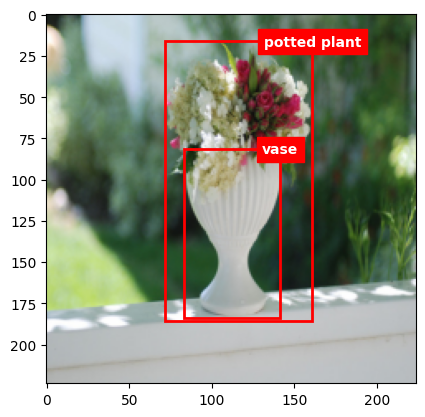

In [13]:
im, (bbox, class_id) = train[2]
image = im.permute(1, 2, 0).numpy()

fig, ax = plt.subplots(1)
ax.imshow(image)
for j in range(len(bbox)):
    rect = patches.Rectangle((bbox[j][0].item(),bbox[j][1].item()),
                              bbox[j][2].item(),
                              bbox[j][3].item(),
                              linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()
    cy = ry + rect.get_height()/500.
    class_name = id_to_cat[id_to_cat['encoded_ids']==class_id[j].item()]['cat_name'].values[0]
    ax.annotate(class_name, (cx, cy), color='white', weight='bold', fontsize=10, ha='center', va='center', backgroundcolor='red')

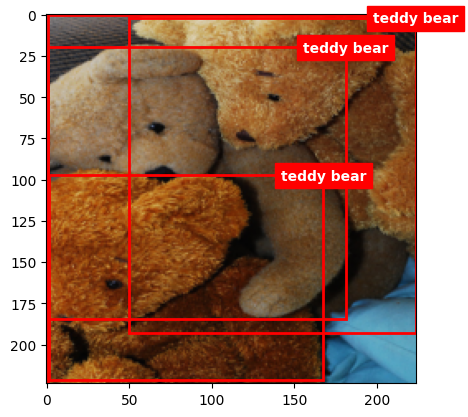

In [15]:
im, (bbox, class_id) = valid[4]
image = im.permute(1, 2, 0).numpy()

fig, ax = plt.subplots(1)
ax.imshow(image)
for j in range(len(bbox)):
    rect = patches.Rectangle((bbox[j][0].item(),bbox[j][1].item()),
                              bbox[j][2].item(),
                              bbox[j][3].item(),
                              linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()
    cy = ry + rect.get_height()/500.
    class_name = id_to_cat[id_to_cat['encoded_ids']==class_id[j].item()]['cat_name'].values[0]
    ax.annotate(class_name, (cx, cy), color='white', weight='bold', fontsize=10, ha='center', va='center', backgroundcolor='red')

# **Data Loader**

In [16]:
im, (bbox, class_id) = valid[5]
bbox, class_id

(tensor([[ 98.2765,  23.5753,  76.5450, 182.7207],
         [ 71.8690, 190.9060, 143.4020,  20.1336]]),
 tensor([ 0, 34], dtype=torch.int32))

In [17]:
def collate_fn(batch):
    images = []
    targets = []
    
    for img, target in batch:
        images.append(img)
        
        boxes, labels = target
        
        if len(boxes) > 0:
            bbox_new = []
            for box in boxes:
                X, Y, W, H = box
                X_max = X + W
                Y_max = Y + H
                b = torch.tensor([X, Y, X_max, Y_max], dtype=torch.float32)
                bbox_new.append(b)
            boxes = torch.stack([torch.tensor(c) for c in bbox_new], dim=0)
        else:
            boxes = torch.empty((0, 4), dtype=torch.float32)
        
        
        labels = torch.tensor(labels, dtype=torch.int64) if len(labels) > 0 else torch.empty((0,), dtype=torch.int64)
        
        targets.append({'boxes': boxes, 'labels': labels})
    
    images = torch.stack(images, dim=0)
    return images, targets


In [18]:
os.cpu_count()

4

In [19]:
train_loader = DataLoader(train, 16, True, collate_fn=collate_fn, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid, 16, False, collate_fn=collate_fn, num_workers=4, pin_memory=True)

# **Model**

## **Forward check**

In [20]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [21]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(1024, 80)
model.backbone.requires_grad_(False)
model.roi_heads.requires_grad_(True)
# model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 123MB/s]  


RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=80, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=320, bias=True)
  )
)

In [22]:
num_trainable_params(model)

14.899615

In [23]:
image, targets = next(iter(train_loader))

In [24]:
model(image, targets)

{'loss_classifier': tensor(4.3827, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.4715, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.2170, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0834, grad_fn=<DivBackward0>)}

# **Train**

## **Find the best LR**

In [25]:
mini_set, _ = random_split(train, [100, len(train)-100])
mini_loader = DataLoader(mini_set, 5, False, collate_fn=collate_fn)

In [26]:
num_epochs = 3
for lr in [0.0005, 0.001, 0.005]:
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(1024, 80)
    model.backbone.requires_grad_(False)
    model.roi_heads.requires_grad_(True)
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr,
                            momentum=0.9, weight_decay=0.0001)

    print('LR : {}'.format(lr))
    
    for epoch in range(num_epochs):
        _, loss = train_one_epoch(model, optimizer, mini_loader)
        print('epoch [{}]:  \t train loss: {} '.format(epoch, loss))

LR : 0.0005


100%|██████████| 20/20 [00:08<00:00,  2.30batch/s, loss=1.73] 


epoch [0]:  	 train loss: 2.537600040435791 


100%|██████████| 20/20 [00:06<00:00,  3.07batch/s, loss=1.61] 


epoch [1]:  	 train loss: 1.4302771091461182 


100%|██████████| 20/20 [00:06<00:00,  3.06batch/s, loss=1.46] 


epoch [2]:  	 train loss: 1.237061858177185 
LR : 0.001


100%|██████████| 20/20 [00:06<00:00,  3.07batch/s, loss=1.85] 


epoch [0]:  	 train loss: 2.229548215866089 


100%|██████████| 20/20 [00:06<00:00,  3.05batch/s, loss=1.42] 


epoch [1]:  	 train loss: 1.369684100151062 


100%|██████████| 20/20 [00:06<00:00,  3.08batch/s, loss=1.28] 


epoch [2]:  	 train loss: 1.1095712184906006 
LR : 0.005


100%|██████████| 20/20 [00:06<00:00,  3.05batch/s, loss=1.4]  


epoch [0]:  	 train loss: 1.9277695417404175 


100%|██████████| 20/20 [00:06<00:00,  3.04batch/s, loss=1.2]  


epoch [1]:  	 train loss: 1.0676873922348022 


100%|██████████| 20/20 [00:06<00:00,  3.08batch/s, loss=1.1]  

epoch [2]:  	 train loss: 0.9785683751106262 


## **Main train loop**

In [27]:
torch.cuda.empty_cache()

In [28]:
best_loss = np.inf

In [29]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(1024, 80)
model.backbone.requires_grad_(False)
model.roi_heads.requires_grad_(True)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [30]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001,
                            momentum=0.9, weight_decay=0.0001)

In [31]:
num_epochs = 5

for epoch in range(num_epochs):
    model, train_loss = train_one_epoch(model, optimizer, train_loader)
    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model, 'model.pt')
        print('model SAVED!')
    print('epoch [{}]:  \t train loss: {} '.format(epoch, train_loss))

100%|██████████| 7393/7393 [1:37:28<00:00,  1.26batch/s, loss=0.503]


model SAVED!
epoch [0]:  	 train loss: 0.6299158930778503 


100%|██████████| 7393/7393 [1:37:33<00:00,  1.26batch/s, loss=0.549]


model SAVED!
epoch [1]:  	 train loss: 0.5195861458778381 


  0%|          | 4/7393 [00:04<2:30:17,  1.22s/batch, loss=0.443]


KeyboardInterrupt: 

# **Test the model**

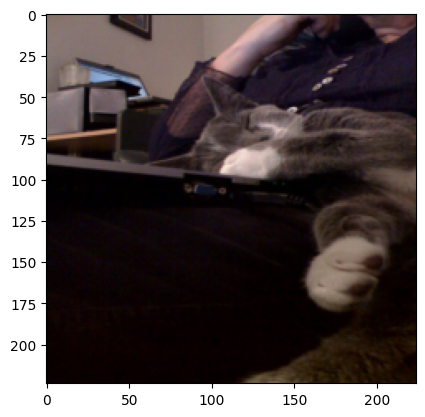

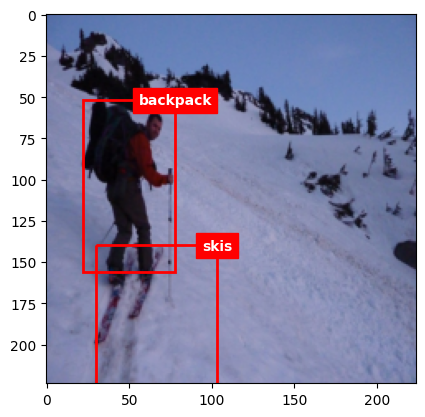

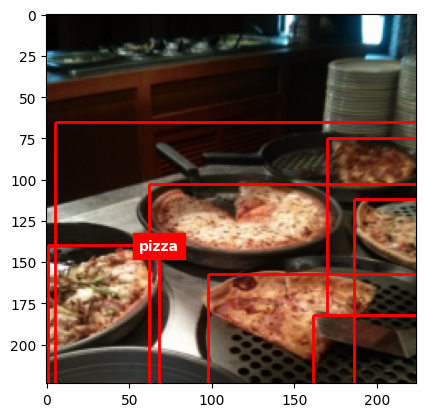

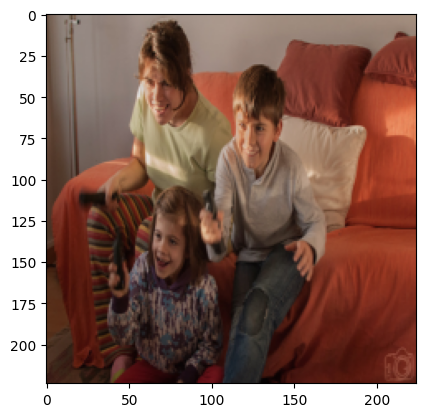

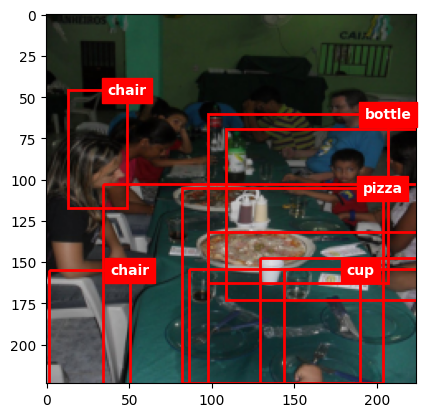

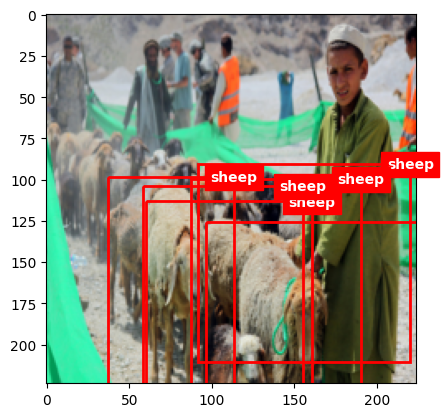

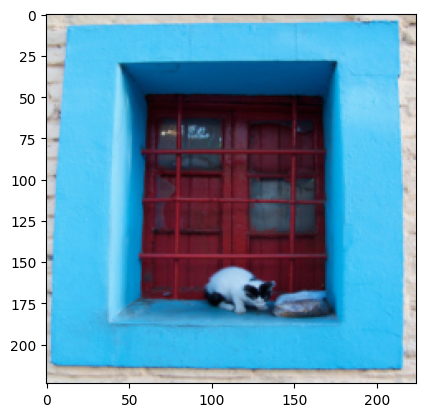

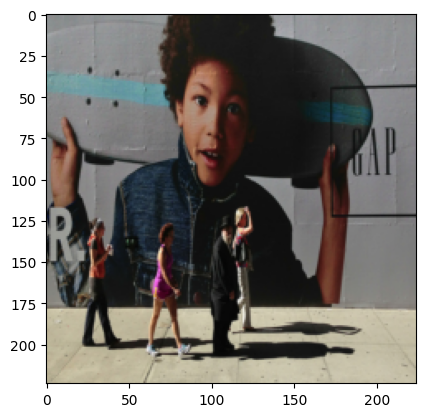

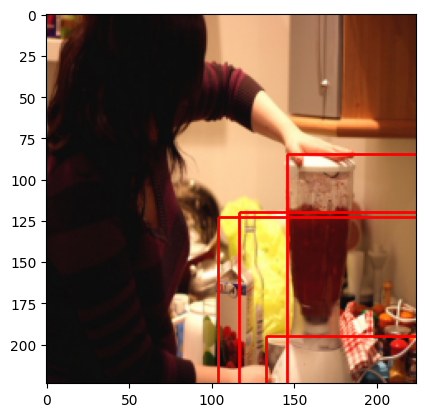

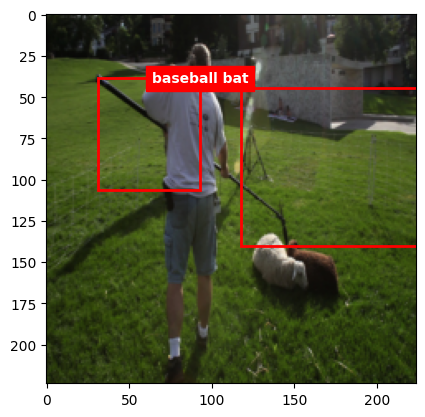

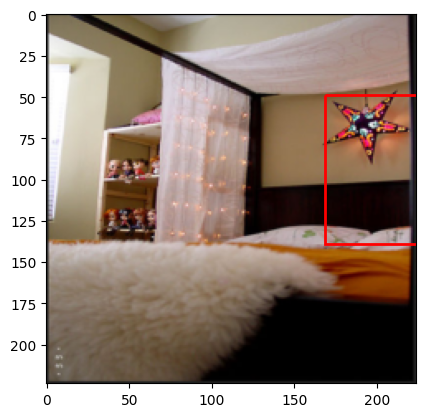

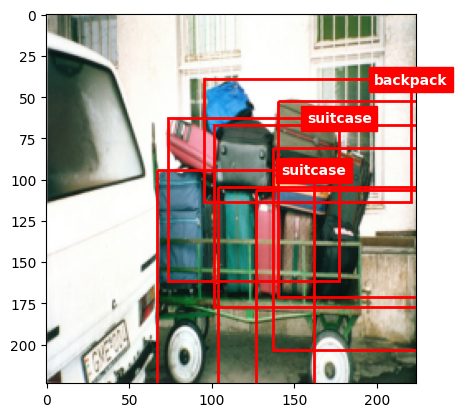

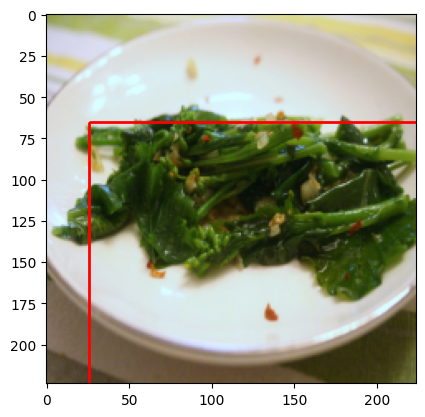

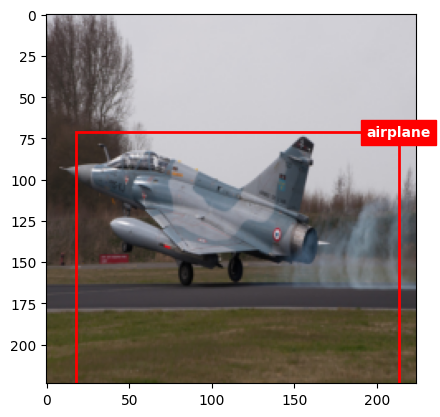

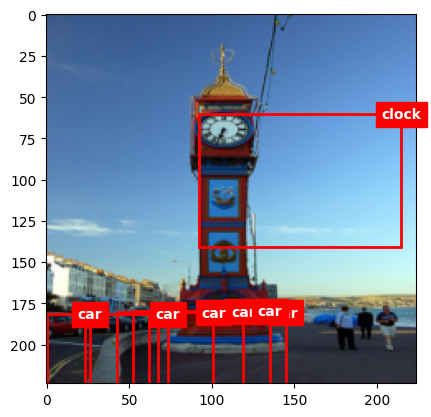

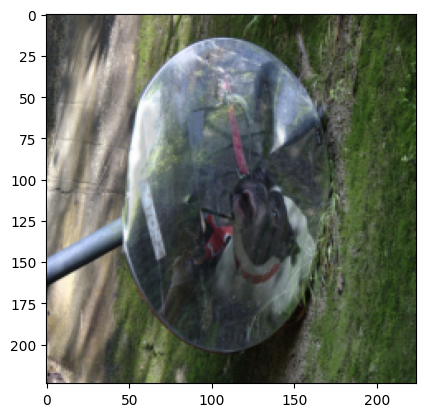

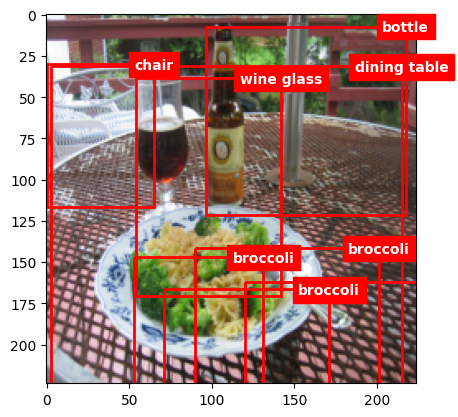

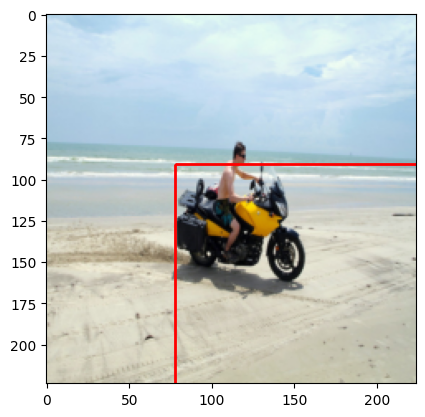

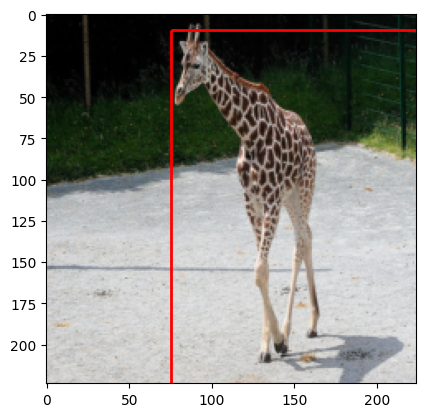

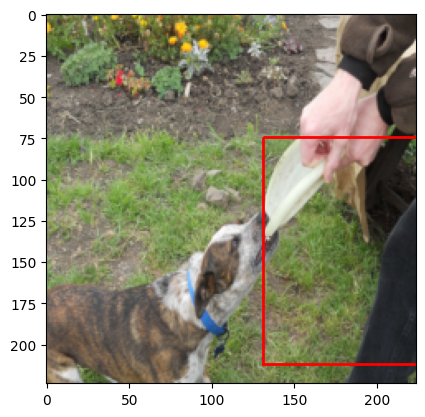

In [42]:
test(model, mini_loader)